#### Energy minimizer

Step 0: energy=-1024.512 boxgas=100.797 boxliq=12.995 totalvol=1026285.695
Step 0: energy_gas=-113.141 energy_liquid=-911.371
Step 100: energy=-4312.600 boxgas=100.861 boxliq=6.121 totalvol=1026285.671
Step 100: energy_gas=-135.047 energy_liquid=-4177.553
Step 200: energy=-3161.931 boxgas=100.856 boxliq=7.347 totalvol=1026285.751
Step 200: energy_gas=-271.392 energy_liquid=-2890.539
Step 300: energy=-4551.524 boxgas=100.858 boxliq=6.950 totalvol=1026285.642
Step 300: energy_gas=-317.204 energy_liquid=-4234.321
Final energy: -5302.080406806921 Final boxgas: tensor(100.8598, requires_grad=True) Final boxliq: tensor(6.9503, grad_fn=<PowBackward0>)


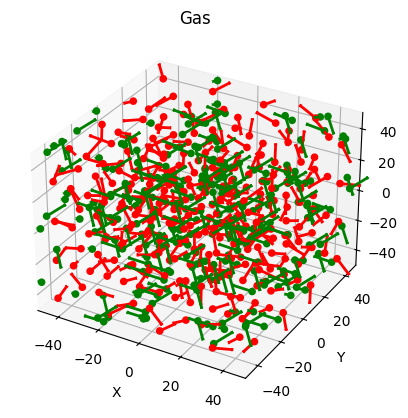

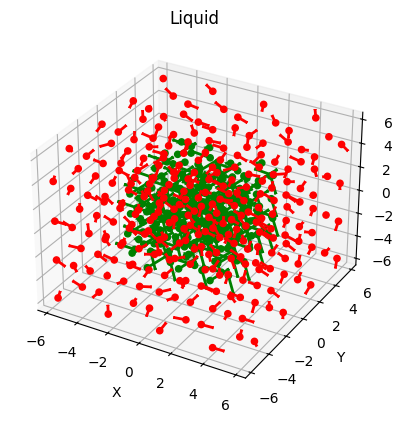

In [17]:
import torch
from main import *
#%matplotlib qt
%matplotlib inline

def loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, exgas, eygas, ezgas, emxgas, emygas, emzgas, exliq, eyliq, ezliq, emxliq, emyliq, emzliq, boxgas, boxliq, ngas, nliq, lr=0.003, iterations=400):
    coordinate_matrix_gas=torch.tensor([rxgas, rygas, rzgas]).requires_grad_()
    boxgas=torch.tensor(boxgas).requires_grad_()
    coordinate_matrix_liq=torch.tensor([rxliq, ryliq, rzliq]).requires_grad_()
    boxliq=torch.tensor(boxliq).requires_grad_()
    orientation_matrix_gas=torch.tensor([exgas, eygas, ezgas]).requires_grad_()
    orientation_matrix_liq=torch.tensor([exliq, eyliq, ezliq]).requires_grad_()

    #pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    #pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    exgas, eygas, ezgas = torch.split(orientation_matrix_gas, 1, dim=0)

    exgaso=(exgas.clone().detach().numpy())*(boxgas.clone().detach().numpy()/10)
    eygaso=(eygas.clone().detach().numpy())*(boxgas.clone().detach().numpy()/10)
    ezgaso=(ezgas.clone().detach().numpy())*(boxgas.clone().detach().numpy()/10)

    exliq, eyliq, ezliq = torch.split(orientation_matrix_liq, 1, dim=0)

    exliqo=(exliq.clone().detach().numpy())*(boxliq.clone().detach().numpy()/10)
    eyliqo=(eyliq.clone().detach().numpy())*(boxliq.clone().detach().numpy()/10)
    ezliqo=(ezliq.clone().detach().numpy())*(boxliq.clone().detach().numpy()/10)

    rxgasc=(rxgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygasc=(rygas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgasc=(rzgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    boxgasc=(boxgas.clone().detach().numpy())

    rxliqc=(rxliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqc=(ryliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqc=(rzliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    boxliqc=(boxliq.clone().detach().numpy())

    optimizer = torch.optim.Adam([coordinate_matrix_gas, boxgas, coordinate_matrix_liq, orientation_matrix_gas, orientation_matrix_liq], lr=lr, weight_decay=0)

    for i in range(iterations):
        optimizer.zero_grad()
        ug = energy(coordinate_matrix_gas, orientation_matrix_gas, boxgas, ngas)
        ul = energy(coordinate_matrix_liq, orientation_matrix_liq, (vol-(boxgas**3))**(1/3), nliq)
        u=ul+ug
        u.backward()
        optimizer.step()
        if i % 100 == 0:
            boxliq=(vol-(boxgas**3))**(1/3)
            print(f"Step {i}: energy={u.item():.3f} boxgas={boxgas.item():.3f} boxliq={boxliq.item():.3f} totalvol={(boxgas.item()**3)+(boxliq.item()**3):.3f}")
            print(f"Step {i}: energy_gas={ug:.3f} energy_liquid={ul:.3f}")

    print('Final energy:', u.detach().numpy(), 'Final boxgas:', boxgas, 'Final boxliq:', boxliq)

    #pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    #pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    coordinate_matrix_liq=(coordinate_matrix_liq/torch.sqrt(torch.sum(orientation_matrix_liq**2, dim=0)))
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    rxgaso=((rxgas-torch.round(rxgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygaso=((rygas-torch.round(rygas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgaso=((rzgas-torch.round(rzgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())

    rxliqo=((rxliq-torch.round(rxliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqo=((ryliq-torch.round(ryliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqo=((rzliq-torch.round(rzliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())

    orientation_matrix_gas=(orientation_matrix_gas/torch.sqrt(torch.sum(orientation_matrix_gas**2, dim=0)))*(boxgas/10)
    exgas, eygas, ezgas = torch.split(orientation_matrix_gas, 1, dim=0)

    exgasc=(exgas.clone().detach().numpy())
    eygasc=(eygas.clone().detach().numpy())
    ezgasc=(ezgas.clone().detach().numpy())

    orientation_matrix_liq=(orientation_matrix_liq/torch.sqrt(torch.sum(orientation_matrix_liq**2, dim=0)))*(boxliq/10)
    exliq, eyliq, ezliq = torch.split(orientation_matrix_liq, 1, dim=0)

    exliqc=(exliq.clone().detach().numpy())
    eyliqc=(eyliq.clone().detach().numpy())
    ezliqc=(ezliq.clone().detach().numpy())

    plotparticles(rxgaso, rygaso, rzgaso, exgaso, eygaso, ezgaso, rxgasc, rygasc, rzgasc, exgasc, eygasc, ezgasc, 'Gas', boxgasc)

    plotparticles(rxliqo, ryliqo, rzliqo, exliqo, eyliqo, ezliqo, rxliqc, ryliqc, rzliqc, exliqc, eyliqc, ezliqc, 'Liquid', boxliqc)

ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, exgas, eygas, ezgas, exliq, eyliq, ezliq, emxgas, emygas, emzgas, emxliq, emyliq, emzliq, boxliq, boxgas, cutgas2, cutliq2, vol = initia()

loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, exgas, eygas, ezgas, emxgas, emygas, emzgas, exliq, eyliq, ezliq, emxliq, emyliq, emzliq, boxgas, boxliq, ngas, nliq, 0.003, 400)

Step 0: energy=-113.141
Step 1: energy=-103.857
Step 2: energy=-111.558
Step 3: energy=-110.654
Step 4: energy=-108.719
Step 5: energy=-109.750
Step 6: energy=-111.366
Step 7: energy=-112.388
Step 8: energy=-112.668
Step 9: energy=-112.678
Step 10: energy=-113.156
Step 11: energy=-114.515
Step 12: energy=-116.634
Step 13: energy=-119.296
Step 14: energy=-122.476
Step 15: energy=-126.233
Step 16: energy=-130.463
Step 17: energy=-134.868
Step 18: energy=-139.110
Step 19: energy=-142.967
Step 20: energy=-146.430
Step 21: energy=-149.647
Step 22: energy=-152.758
Step 23: energy=-155.813
Step 24: energy=-158.794
Step 25: energy=-161.644
Step 26: energy=-164.314
Step 27: energy=-166.772
Step 28: energy=-168.999
Step 29: energy=-170.987
Step 30: energy=-172.739
Step 31: energy=-174.266
Step 32: energy=-175.589
Step 33: energy=-176.734
Step 34: energy=-177.727
Step 35: energy=-178.601
Step 36: energy=-179.394
Step 37: energy=-180.148
Step 38: energy=-180.891
Step 39: energy=-181.637
Step 40: e

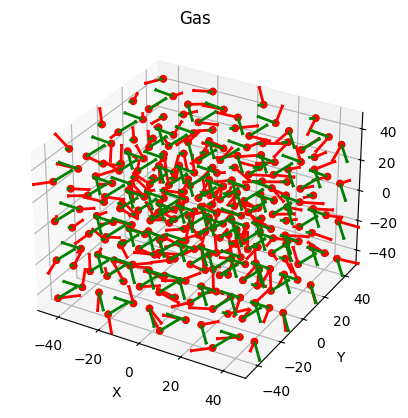

In [14]:
import torch
from main import *
#%matplotlib qt
%matplotlib inline

def loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxgas, boxliq, ngas, nliq, lr=0.003, iterations=400):
    coordinate_matrix_gas=torch.tensor([rxgas, rygas, rzgas]).requires_grad_()
    orientation_matrix=torch.tensor([ex, ey, ez]).requires_grad_()

    #pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    #orientation_matrix=(orientation_matrix/torch.sqrt(torch.sum(orientation_matrix**2, dim=0)))*5
    ex, ey, ez = torch.split(orientation_matrix, 1, dim=0)

    exo=(ex.clone().detach().numpy())*(boxgas/10)
    eyo=(ey.clone().detach().numpy())*(boxgas/10)
    ezo=(ez.clone().detach().numpy())*(boxgas/10)

    rxgasc=(rxgas.clone().detach().numpy())*boxgas
    rygasc=(rygas.clone().detach().numpy())*boxgas
    rzgasc=(rzgas.clone().detach().numpy())*boxgas
    boxgasc=boxgas

    optimizer = torch.optim.Adam([orientation_matrix], lr=lr, weight_decay=0)

    for i in range(iterations):
        optimizer.zero_grad()
        #ug, dg, tg, mg, sg, eg, scaleg, bg = energy(coordinate_matrix_gas, orientation_matrix, boxgas, ngas)
        loss = energy(coordinate_matrix_gas, orientation_matrix, boxgas, ngas)
        #ul, dl, tl, ml, sl, el, scalel, bl = energy(coordinate_matrix_liq, orientation_matrix, (vol-(boxgas**3))**(1/3), nliq)
        #ul = 0
        #u=ul+ug
        loss.backward()
        optimizer.step()
        if i % 1 == 0:
            print(f"Step {i}: energy={loss.item():.3f}")
            #print(f"Step {i}: energy_gas={ug:.3f} energy_liquid={ul:.3f}")

    print('Final energy:', loss.detach().numpy(), 'Final boxgas:', boxgas)

    #pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    orientation_matrix=(orientation_matrix/torch.sqrt(torch.sum(orientation_matrix**2, dim=0)))*(boxgas/10)
    ex, ey, ez = torch.split(orientation_matrix, 1, dim=0)

    exc=(ex.clone().detach().numpy())
    eyc=(ey.clone().detach().numpy())
    ezc=(ez.clone().detach().numpy())
 
    rxgaso=((rxgas-torch.round(rxgas)).clone().detach().numpy())*boxgas
    rygaso=((rygas-torch.round(rygas)).clone().detach().numpy())*boxgas
    rzgaso=((rzgas-torch.round(rzgas)).clone().detach().numpy())*boxgas

    plotparticles(rxgaso, rygaso, rzgaso, exo, eyo, ezo, rxgasc, rygasc, rzgasc, exc, eyc, ezc, 'Gas', boxgasc)

ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, exgas, eygas, ezgas, exliq, eyliq, ezliq, emxgas, emygas, emzgas, emxliq, emyliq, emzliq, boxliq, boxgas, cutgas2, cutliq2, vol = initia()

loop(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, exgas, eygas, ezgas, emxgas, emygas, emzgas, boxgas, boxliq, ngas, nliq, 0.1, 1000)